<p style="text-align: center;font-size: 40pt">Overview of lidars</p>

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from IPython.display import HTML, YouTubeVideo
import numpy as np
import scipy.stats as stats
import math

%run ./scripts/helper_func.py
path = "{0}/common/scripts/style.py".format(get_root_path())
%run $path

# Introduction

The name LiDAR was originally an acronym for Light Detection And Ranging, but as this technology gained popularity, the word began to exist on its own.
Lidars are one of the most common sensors one can find on autonomous vehicles.
The reason behind their popularity is that they are becoming more and more affordable and provide rich 3D information about their surroundings.
In this lesson, you will learn the basics of how lidars work and what are their limitations.
But first, here is the visualisation of some data gathered by a 3D lidar fixed on the roof of a car:

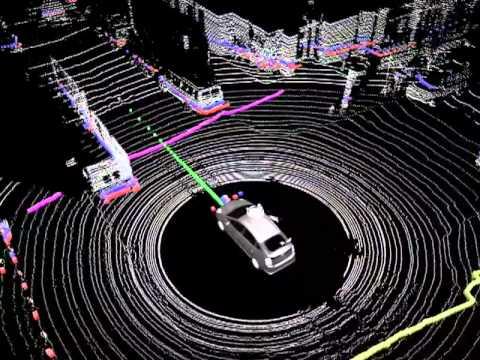

In [58]:
YouTubeVideo('nXlqv_k4P8Q', width=720, height=480)

# Basic principle

## In one dimension
First of all, what is a lidar?
Well, a 1D lidar would be a [laser rangefinder](https://en.wikipedia.org/wiki/Laser_rangefinder), you know, those small devices used to measure a distance.
They send a laser pulse on an object and measure how much time it takes for the pulse to bounce on it and come back.
Knowing this time and the speed at which the pulse travels (the speed of light), one can compute the distance between the lidar and the object.

<p style="text-align: center;">
<img src="images/1d_lidar.svg" width="50%" alt="By RCraig09 - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=89646954">
</p>

## In two dimensions
If you take this laser and point it to a mirror rotating along the Z axis, you can _scan_ a line around the sensor, meaning you now have a 2D lidar.
The output of such a lidar is no longer a single distance (or point), but a set of points (i.e. a point cloud) in 2D.
The position of a point is computed using the time it takes for a laser pulse to bounce back to the lidar as well as the mirror angle at the moment at which the pulse was fired.
This will give you an angle and a distance (i.e. [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system)), which can then be converted to [2D Cartesian coordinates](https://en.wikipedia.org/wiki/Cartesian_coordinate_system#Cartesian_coordinates_in_two_dimensions) (in the frame of the lidar).

<p style="text-align: center;">
<img src="images/2d_lidar.gif" width="15%" alt="By Mike1024 - Drawn and animated by Mike1024, Public Domain, https://commons.wikimedia.org/w/index.php?curid=3688414">
</p>

## In three dimensions
Finally, if you take multiple lasers (or channels or beams) and point them to the good old rotating mirror, you can _scan_ multiple lines (at different heights) around the sensor, which means you now have a 3D lidar.
The following image shows the output of such a lidar.
If you look carefully at the layout of the points, you will be able to see the scan lines (or rings) of the different lasers around the lidar.
When computing the position of a point in 3D, the difference with 2D is that positions are computed using two angles: the vertical angle (i.e. channel angle) as well as the horizontal/azimuth angle (i.e. mirror angle).
Therefore, you will have two angles and one distance (i.e. [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system)), which can then be converted to [3D Cartesian coordinates](https://en.wikipedia.org/wiki/Cartesian_coordinate_system#Cartesian_coordinates_in_three_dimensions) (in the frame of the lidar).

<p style="text-align: center">
<img src="images/3d_lidar.jpg" width="50%" alt="Visualization of a LiDAR point cloud. By Graham Murdock for Popular Science">
</p>

# Now, in real life

In real life though, everything is not so simple.
Mostly, things go bad because of the physics of light propagation.

## Laser pulses are not instantaneous
Laser pulses are not just a punctual burst of energy, as we might think.
When a pulse is emitted by a lidar, the intensity released in function of time looks a little like this:

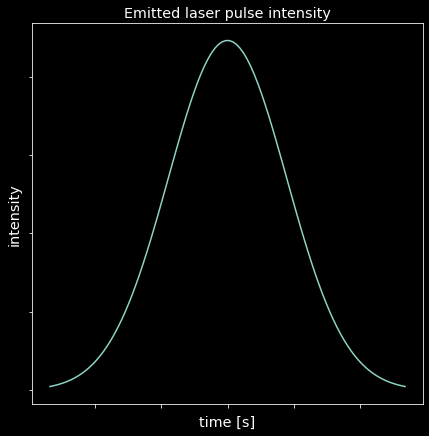

In [2]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title(r"Emitted laser pulse intensity")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('time [s]')
ax.set_ylabel('intensity')

mu = 0
variance = 20
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
_ = ax.plot(x, stats.norm.pdf(x, mu, sigma), color="C0")

When the pulse is reflected back, the intensity recorded by the lidar looks similar.
Even though this intensity variation happens in a really short amount of time, we cannot consider it as an instantaneous peak, since we are dealing with things happening at the speed of light here.
This leads to the following problem: when the pulse bounces back to the lidar, how to determine exactly the moment at which it arrives?
Most lidars have a threshold and when the intensity goes above and back below it, they take the time in the middle and state that this is when the pulse came back.
However, in some cases, the intensity recorded by the lidar looks more like this:

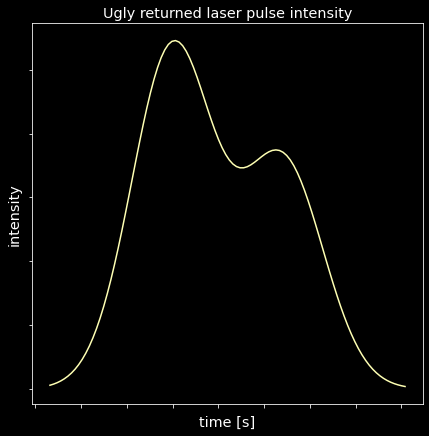

In [3]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title(r"Ugly returned laser pulse intensity")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('time [s]')
ax.set_ylabel('intensity')

mu_1 = 0
variance_1 = 20
sigma_1 = math.sqrt(variance_1)

mu_2 = 12
variance_2 = 20
sigma_2 = math.sqrt(variance_2)

x = np.linspace(mu_1 - 3*sigma_1, mu_2 + 3*sigma_2, 100)
_ = ax.plot(x, 0.6*stats.norm.pdf(x, mu_1, sigma_1) + 0.4*stats.norm.pdf(x, mu_2, sigma_2), color="C1")

This kind of intensity reading can lead to a bad detection of the time at which the pulse came back to the lidar, thus leading to a bad measure of distance.

## Laser pulses are not perfectly reflected back to lidars
Most of the time, [diffuse reflection](https://en.wikipedia.org/wiki/Diffuse_reflection) takes place and laser pulses are reflected in all directions when they hit an object, meaning that only a portion of their energy comes back to the lidar.
This leads to returned pulse intensities looking like this:

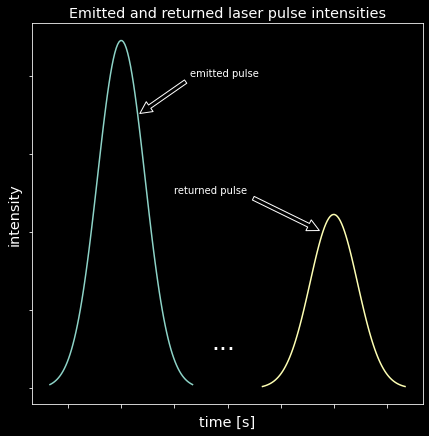

In [4]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title(r"Emitted and returned laser pulse intensities")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('time [s]')
ax.set_ylabel('intensity')

mu = 0
variance = 20
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
_ = ax.plot(x, stats.norm.pdf(x, mu, sigma))
_ = ax.annotate('emitted pulse', xy=(3, 0.07), xytext=(13, 0.08), arrowprops=dict(facecolor='black', shrink=0.05))

_ = ax.text(17, 0.01, '...', fontsize=25)

mu = 40
variance = 20
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
_ = ax.plot(x, stats.norm.pdf(x, mu, sigma)*0.5)
_ = ax.annotate('returned pulse', xy=(38, 0.04), xytext=(10, 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

In some cases, the intensity of the returned pulse is so low that it is below the intensity threshold of the lidar and nothing is measured.
The intensity of the returned pulse varies in function of the distance to the surface, the incidence angle between the laser and the surface as well as the reflective properties of the surface.
If the surface is too polished, a [specular reflection](https://en.wikipedia.org/wiki/Specular_reflection) can even occur and the whole pulse will get reflected in a different direction.
Finally, some surfaces absorb completely the pulses.
This is the case of black surfaces and of water, which absorbs infrared wavelengths.

## Reflections
When a specular reflection occurs, the reflected pulse sometimes bounces on a second surface, which reflects the laser pulse back to the lidar.
This phenomenon is called a reflection, or virtual point.
For the lidar, it is as if the laser pulse had traveled in a straight line, as illustrated below :

<p style="text-align: center">
<img src="images/virtual_point.png" width="50%" alt="Visualization of a LiDAR point cloud. By Graham Murdock for Popular Science">
</p>

Because the laser pulse gets reflected twice, the distance it travels is bigger than if it had been reflected only once, causing the point to be placed behind the first surface it hits.
Reflections can happen when the scanned area contains reflective objects, such as mirrors or windows.

## Laser beams are shaped like cones
Shocking right?
Even though we are tempted to consider lidar laser beams like zero-width lines, in fact, they are shaped like cones (with their tip located in the lidar).
When a laser beam hits a surface, it looks more like this:

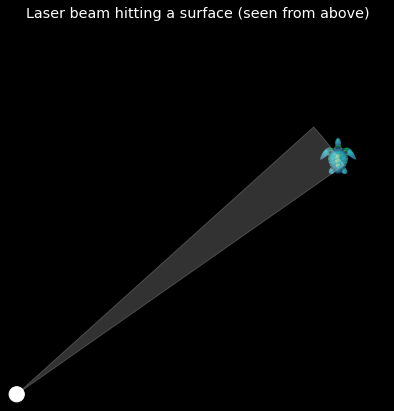

In [5]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title(r"Laser beam hitting a surface (seen from above)")
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

_ = ax.add_patch(patches.Wedge((0.025, 0.025), 1.05, 35, 42, color='white', alpha=0.2))
_ = ax.add_patch(patches.Circle((0.025, 0.025), radius=0.02, color='white'))
img = plt.imread("images/turtle.png")
_ = ax.imshow(img, extent=[0.82, 0.92, 0.6, 0.7])

In this case, when the laser pulse comes back to the lidar, there is no way of knowing exactly where the object was within the cone of the beam.
This means that the farther you are from the lidar, the less precision you have, because the beam width increases with distance.
In fact, the surface at the end of a beam cone increases quadratically with distance, as shown below :

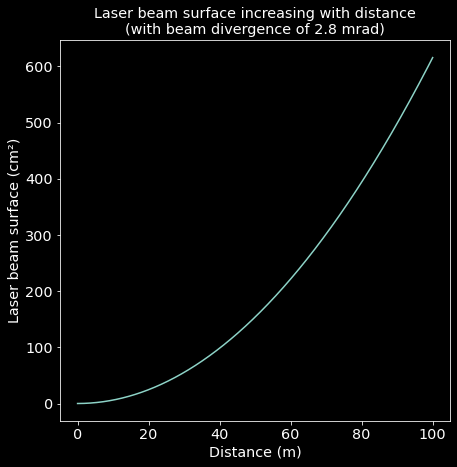

In [50]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title("Laser beam surface increasing with distance\n(with beam divergence of 2.8 mrad)")
ax.set_xlabel("Distance (m)")
ax.set_ylabel(r"Laser beam surface (cm²)")

x = np.linspace(0.0, 100.0, 1000)
_ = ax.plot(x, np.pi * (np.tan(0.0014) * x * 100)**2)

A side effect of the shape of lidar laser beams is the following: when lidar data is taken on roadsides, traffic signs appear bigger than they are in reality.
This is caused by the fact that those signs are coated with a highly reflective material.
Even if only a small portion of the beam cone hits the sign, it is so reflective that a lot of intensity will get reflected back to the lidar, and the returned pulse will be measured.
If this coating was not present, the returned pulses would not be strong enough.
The signs will therefore intercept more laser beams than normal surfaces, causing them to look bigger.

## Shadow points
Shadow points are points that do not really exist.
They are the result of averaging portions of a pulse reflected by different surfaces.
Indeed, because laser beams have a width, one emitted pulse can cause multiple intensity peaks at different times in the returned pulse.
Here is an example of how it could happen:

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
plt.close(fig)
ax.set_title("Object geometry causing two \n intensity peaks in the returned pulse")

ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

_ = ax.add_patch(patches.Wedge((0.025, 0.025), 1.055, 35, 42, color='white', alpha=0.2))
_ = ax.add_patch(patches.Circle((0.025, 0.025), radius=0.02, color='white'))
_ = ax.add_patch(patches.Polygon((np.array([[0.75, 0.7], [0.8, 0.64], [0.848, 0.678], [0.9, 0.61], [0.96, 0.658], [0.86, 0.785]]))))
poly_1 = patches.Arc((0.025, 0.025), 0.05, 0.05, 0, theta1=35, theta2=38.5, linewidth=3)
ax.add_patch(poly_1)
poly_2 = patches.Arc((0.025, 0.025), 0.05, 0.05, 0, theta1=38.5, theta2=42, linewidth=3)
ax.add_patch(poly_2)
point = patches.Circle((0.83, 0.66), radius=0.02, color='red', alpha=0)
_ = ax.add_patch(point)

def draw(t):
    if t > 2.11:
        poly_1.center = (1.716, 1.287)
        poly_1.angle = 180
    poly_1.width = t
    poly_1.height = t
    if t > 2:
        poly_2.center = (1.551, 1.317)
        poly_2.angle = 180
    poly_2.width = t
    poly_2.height = t
    if t > 4:
        poly_2.set_alpha(0)
    if t > 4.22:
        poly_1.set_alpha(0)
        point.set_alpha(1)
        point.radius = 0.0741 - 0.0128 * t
    
    return (poly_1, poly_2, point)
HTML(animation.FuncAnimation(fig, func=draw, frames=np.arange(0.025, 5, 0.02), interval=40, blit=True, repeat=False).to_html5_video())

In this case, the returned pulse intensity would look something like this:

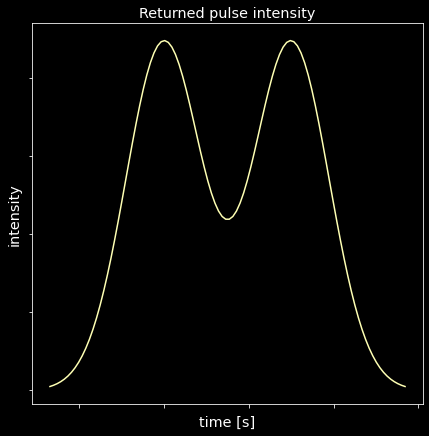

In [7]:
if 'fig' in globals():
    plt.close(fig)

fig = plt.figure(figsize=(7,7))

#------------------------
ax1 = fig.add_subplot(111)
ax = ax1
ax.set_title(r"Returned pulse intensity")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('time [s]')
ax.set_ylabel('intensity')

mu_1 = 0
variance_1 = 20
sigma_1 = math.sqrt(variance_1)

mu_2 = 15
variance_2 = 20
sigma_2 = math.sqrt(variance_2)

x = np.linspace(mu_1 - 3*sigma_1, mu_2 + 3*sigma_2, 100)
_ = ax.plot(x, 0.5*stats.norm.pdf(x, mu_1, sigma_1) + 0.5*stats.norm.pdf(x, mu_2, sigma_2), color="C1")

If the intensity in the middle section of this plot is above the lidar intensity threshold, the distance computed for the point will be located between the two surfaces as shown by the red dot in the animation above.
It results in a point being placed in a spot where nothing was really measured.
Shadow points are present in lidar data when things are placed in front of each others in a scan.
Some lidars support multiple _echoes_ or _returns_ and will place two points at different distances instead.

## Laser incidence angle distorts the measurements
As surprising as this might sound, when the incidence angle between the laser beam and a surface is too high, the distance measured by the lidar is smaller than it should.
This is due to the fact that most of the laser pulse intensity is reflected back to the lidar when the first portion of the beam cone hits the surface, as illustrated here:

<p style="text-align: center">
<img src="images/bias.png" width="50%">
</p>

Here, the color represents the intensity distribution of the laser pulse.
In this case, because we are intersecting a cone and a plane, this distribution is shaped like an ellipse.
Most of the intensity of the laser pulse is concentrated on the side of the ellipse which is closer to the lidar, rather than in its center, like it would with a small incidence angle.
This results in a distance measurement smaller than reality, because most of the beam intensity is reflected back to the lidar before the cone center hits the surface.
Although this bias is mostly caused by the incidence angle between the laser beam and the surface it hits, it is also influenced by distance.
Also, between lidar models, differences exist because of the different beam divergences, electronic components, etc.

# Lidar specifications
In order to compare lidars, it is important to be able to read the specifications documented in their datasheets.
Here are the most common ones for mobile terrestrial lidars.
For the sake of learning, they are presented separately, but it is important to remember that they influence each other.
For example, if the scan rate of a lidar is set to its maximum, its maximum range might decrease.
This kind of details is usually hard to find when reading lidar specifications.

## Laser beam divergence
The laser beam divergence is the opening angle of the beam cone.
It is usually expressed in milliradians or millidegrees.
Here is an illustration of the laser beam divergence of a lidar, seen from above:

<p style="text-align: center">
<img src="images/divergence.png" width="50%">
</p>

## Accuracy and precision
Although their meaning is close, accuracy and precision are two different things.
A high accuracy means that the measurements are close to to the real value we want to measure.
On the other hand, a high precision means that the measurements are close to each other for a same value we want to measure.

<p style="text-align: center">
<img src="images/accuracy_vs_precision.png" alt="https://geoslam.com/blog/2016/05/31/laser-scanning-accuracy/" width="50%">
</p>

Accuracy and precision can both be given in terms of range or laser angles.
Range refers to the distance measured for a point while laser angles refer to the horizontal and vertical angles of the direction in which a pulse is fired.
In the context of range, accuracy and precision are usually expressed in centimeters.
In the context of laser angles, they are usually expressed in degrees or radians.

## Range resolution
The range resolution is the smallest range difference necessary between two objects to be able to distinguish them in a scan.
It is usually expressed in meters.
If the range difference between two objects is smaller than this resolution, they will be at the same distance from the lidar in the scans.

## Field of view
The horizontal and vertical field of views are respectively the horizontal and vertical areas captured by a lidar.
They are usually expressed in degrees or radians.

## Angular resolution
The horizontal (or azimuth) angular resolution is the smallest horizontal angle difference necessary between two objects to be able to distinguish them in a scan, expressed in degrees or radians.
On the other hand, the vertical angular resolution is the smallest vertical angle difference necessary between two objects to be able to distinguish them in a scan, expressed in degrees or radians.
If the angle difference between two objects is smaller than the angular resolution, there will be no space between them in the scans.

## Horizontal and vertical resolution
Horizontal resolution is the number of points per row in a scan.
It can be computed as follows:
\begin{aligned}
\text{horizontal resolution} = \frac{\text{horizontal field of view}}{\text{horizontal angular resolution}} + 1
\end{aligned}

Vertical resolution is the number of rows of points in a scan, also called channels or beams.
It can be computed as follows:
\begin{aligned}
\text{vertical resolution} = \frac{\text{vertical field of view}}{\text{vertical angular resolution}} + 1
\end{aligned}

## Scan rate
The scan rate is the number of scans generated per second by a lidar.
In the case of 360-degree lidars, it is also called rotation rate.
It is usually expressed in hertz.

## Points per second
Points per second are the total number of points generated per second by a lidar.
It can be computed as follows:
\begin{aligned}
\text{points per second} = \text{horizontal resolution} \times \text{vertical resolution} \times \text{scan rate}
\end{aligned}

## Laser safety class
[Laser safety classes](https://en.wikipedia.org/wiki/Laser_safety#Classification) were invented to classify lasers depending on their wavelength and output power.
The goal of this classification system is to avoid injuries by defining safety procedures to follow when operating lasers.
Most mobile terrestrial lidars use class-1 lasers, which are eye-safe.

## Range
Minimum and maximum ranges are respectively the smallest and biggest distances from a target from which a lidar can operate.
It is usually expressed in meters.

# Conclusion
Here is all there is to know about lidars in the context of autonomous vehicles.
I hope you now have a better understanding of how those sensors work and what are their limitations.

&#8635; [Go back to the list of lessons](0-overview.ipynb)